### Sensitivity of the breakup to variations in ice thickness and wind speed

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no


In [7]:
# allow plots to be interactive in the notebook
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.dates as mdates
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import cmocean 
import datetime as dt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pyplot as plt
from pynextsim.projection_info import ProjectionInfo
import calc_leadfrac as clf

In [8]:
def prepare_grid():
    extent = [-110, 200, 67, 90]
    proj = ProjectionInfo() # default nextsim projection

    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent, 
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,)
    return grid


def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 

In [3]:
# load data 

# setup directories 
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'

# open Arcleads interpolated to nextsim grid
arc = xr.open_dataset(rootdir + '/home/rheinlender/data/Arcleads/Arcleads_interp2nextsim_20130212-20130313.nc')

# Open neXtSIM data
expts = ["expt_01_wrf10/outputs/", "expt_05_wrf10-sitx0.5/outputs/","expt_06_wrf10-sitx1.5/outputs/", 
         "expt_07_wrf10-sitx2.0/outputs/", "expt_01_wrf10-nodyn/outputs/"]

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
ds3 = xr.open_dataset(files[3])
ds4 = xr.open_dataset(files[4])

dslist = [ds0, ds1, ds2, ds3]

time = ds0['time'].time.values.astype('datetime64[ms]').astype('O')
nlon = ds0.longitude.values
nlat = ds0.latitude.values


In [4]:
# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410

bbox = (x0,x1,y0,y1)

# calculate MODIS lead area fraction
MODIS_laf = clf.calc_leadAreaFrac_MODIS(arc, bbox)
MODIS_laf = MODIS_laf*100
MODIS_time = MODIS_laf['time'].time.values.astype('datetime64[ms]').astype('O')

# Plot timeseries of ice velocity, wind speed and lead fraction in the Beaufort Sea

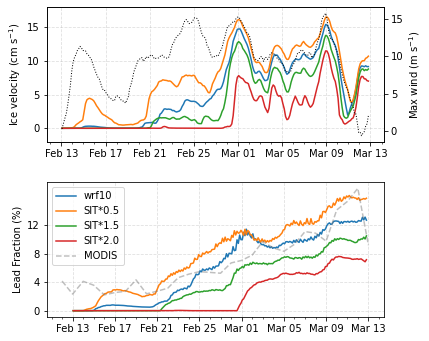

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/icevel_leadfrac_beaufort-std_0.5_1.5_2.0.png


In [5]:
labelstr = ["wrf10", "SIT*0.5", "SIT*1.5", "SIT*2.0", 'MODIS']
fig, ax = plt.subplots(2,1, figsize=(6,5))

for i, ds in enumerate(dslist):
 
    # calculate nextsim lead area fraction
    nc_laf, nlead = clf.calc_leadAreaFrac_nextsim(ds, 0.05, bbox)
    nc_laf = nc_laf*100   # convert to %
    
    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    icevel = ds['icevel'].sel(x=slice(x0,x1), y=slice(y0,y1)).mean(dim=('x','y'))*1e2 # cm/s
   
    ## Plotting
    l2 = ax[0].plot(time, icevel, label=labelstr[i])
    l3 = ax[1].plot(time, nc_laf, label=labelstr[i])

# add maximum ywind along transect
ax2 = ax[0].twinx()
l0 = ax2.plot(time, ds0['wndy'].sel(x=100, y=slice(180, 450)).max(dim=('y')), 
              color='black', 
              linewidth='1', 
             # alpha=0.9,
              linestyle=':')

# add MODIS lead area fraction
l1 = ax[1].plot(MODIS_time, MODIS_laf, label=labelstr[-1],
                color='grey', 
                alpha=0.5, 
                ls='--',
                lw='1.5')    
    
# legends 
ax2.set_ylabel("Max wind (m s$^{-1}$)")
ax[0].set_ylabel("Ice velocity (cm s$^{-1}$)")
ax[1].set_ylabel("Lead Fraction (%)")

for axes in ax.flat:
    axes.grid(linestyle='--', alpha=0.4)
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    axes.xaxis.set_major_formatter(dtFmt)
    axes.xaxis.set_minor_locator(days)
    
# label stuff
ax[0].set_ylim([-2,18])
ax[1].legend(loc='upper left')# add legend 
ax[1].yaxis.set_ticks(np.arange(0, 12+4, 4))
#ax[0].set_xticklabels([''])

fig.subplots_adjust(bottom=0.1, top=0.96, left=0.12, right=0.9, wspace=0.1, hspace=0.3)
plt.show()

# save figure
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'icevel_leadfrac_beaufort-std_0.5_1.5_2.0.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Plot maps of integrated damage for the sensitivity expts

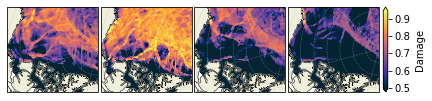

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/damage_beaufort_2013-02-19-2013-03-13_sensitivity_expts.png


In [11]:
t1 = '2013-02-19'
t2 = '2013-03-13'

cmap=cmocean.cm.thermal
clim=[0.5, 0.95]
clevs = np.arange(clim[0], clim[1], (clim[1]-clim[0])/100)
grid = prepare_grid()

# make figure
fig,gs = make_figure(6,2,1,4) 
for i, ds in enumerate(dslist):
    ax = plt.subplot(gs[i],projection=ccrs.NorthPolarStereo(central_longitude=300), extent=[-110, 200, 67, 90])
    
    dam_ave = ds['damage'].sel(time=slice(t1,t2)).mean(dim='time')
    
    # prepare axes
    ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])

    cs = ax.contourf(dam_ave, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
                     cmap=cmap, levels=clevs,  extend='both')

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")

cax = inset_axes(fig.axes[3],
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=fig.axes[3].transAxes,
                    borderpad=0)

plt.colorbar(cs, cax=cax, label='Damage', ticks=[0.5, 0.6, 0.7, 0.8, 0.9])
    
plt.subplots_adjust(wspace=0.03, hspace=0, top=0.95, bottom=0.1, left=0.02, right=0.88)
plt.show()   

title_string =("wrf10", "SIT*0.5", "SIT*1.5", "SIT*2.0")
for i in range(0,len(dslist)):
    ax=fig.axes[i]
    ax.set_title(title_string[i])

# save figure
figname = os.path.join(outpath_plots,
      '%s%s_%s-%s_%s' % (outpath_plots, 'damage_beaufort', t1, t2, 'sensitivity_expts.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')